In [128]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [129]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [130]:
len(words)


32033

In [131]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi={s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [200]:
# build the dataset
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# training, dev, and test split
# 80%, 10%, 10% 
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])




torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [133]:
C = torch.randn((27,2))


In [199]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)


In [137]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2,:]], 1).shape


torch.Size([228146, 6])

In [138]:
torch.cat(torch.unbind(emb, 1), 1).shape


torch.Size([228146, 6])

In [139]:
a = torch.arange(18)


In [140]:
a.shape


torch.Size([18])

In [141]:
a.view(3, 3, 2)


tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [142]:
emb.shape


torch.Size([228146, 3, 2])

In [155]:
emb.view(32,6)


RuntimeError: shape '[32, 6]' is invalid for input of size 1368876

In [156]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)


In [157]:
h.shape


torch.Size([228146, 100])

In [158]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)


In [159]:
logits = h @ W2 + b2
logits.shape


torch.Size([228146, 27])

In [160]:
counts = logits.exp()
prob = counts/counts.sum(1, keepdim=True)


In [161]:
loss = -prob[torch.arange(32), Y].log().mean()
loss


IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

Make it respectable

In [236]:

Xtr.shape, Ytr.shape


(torch.Size([182441, 3]), torch.Size([182441]))

In [278]:
g =torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


In [279]:
sum(p.nelement() for p in parameters)


11897

In [280]:

for p in parameters:
    p.requires_grad = True



In [227]:
lre = torch.linspace(-3, 0,1000)
lrs = 10**lre


In [281]:
lri = []
lossi = []
stepi = []


In [295]:
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] #(32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2 # (32, 27)
    # counts=logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())


    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    # lr = lrs[i]
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    stepi.append(i)
    # lri.append(lr)
    lossi.append(loss.log10().item()) 


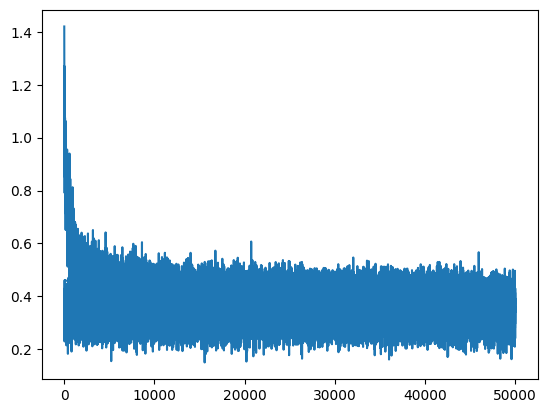

In [290]:
plt.plot(stepi, lossi)


In [296]:
print(loss.item())


2.0359060764312744


In [297]:
emb = C[Xdev] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss.item()


2.164663791656494

In [298]:
emb = C[Xtr] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss.item()


2.106444835662842

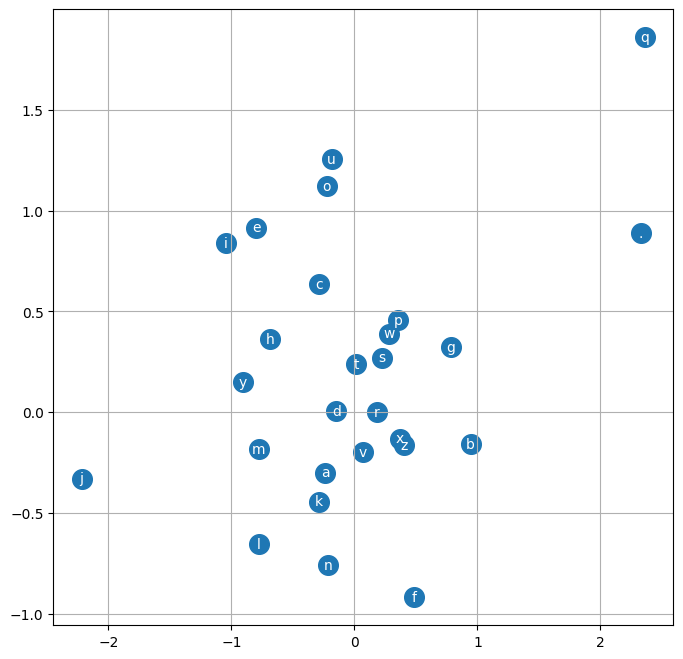

In [299]:
plt.figure(figsize = (8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s =200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha = "center", va="center", color="white")
plt.grid("minor")
